In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = 'RAE_LowerAndEvenSNR_ExtendedRange_MoreLeftOut_Combined1Distribution'
base_name = 'LowerAndEvenSNR_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{base_name}_ForManuscript_Conc.npy')

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 9709.6056, Test Loss: 2155.1079
Epoch [2/1000], Train Loss: 8545.5703, Test Loss: 2122.8440
Epoch [3/1000], Train Loss: 8426.5337, Test Loss: 2061.0495
Epoch [4/1000], Train Loss: 8181.3522, Test Loss: 2007.8566
Epoch [5/1000], Train Loss: 7675.1415, Test Loss: 1792.7494
Epoch [6/1000], Train Loss: 6509.9407, Test Loss: 1369.3598
Epoch [7/1000], Train Loss: 4661.9926, Test Loss: 991.5224
Epoch [8/1000], Train Loss: 3398.6022, Test Loss: 761.7028
Epoch [9/1000], Train Loss: 2622.8277, Test Loss: 601.6721
Epoch [10/1000], Train Loss: 2117.4698, Test Loss: 474.6890
Epoch [11/1000], Train Loss: 1762.0425, Test Loss: 417.3040
Epoch [12/1000], Train Loss: 1534.7702, Test Loss: 366.3362
Epoch [13/1000], Train Loss: 1340.9891, Test Loss: 328.9773
Epoch [14/1000], Train Loss: 1183.4512, Test Loss: 283.8139
Epoch [15/1000], Train Loss: 1052.3327, Test Loss: 258.3864
Epoch [16/1000], Train Loss: 942.8482, Test Loss: 224

Epoch [140/1000], Train Loss: 246.8015, Test Loss: 65.1956
Epoch [141/1000], Train Loss: 248.4406, Test Loss: 65.8475
Epoch [142/1000], Train Loss: 250.9072, Test Loss: 66.6799
Epoch [143/1000], Train Loss: 249.9140, Test Loss: 65.1895
Epoch [144/1000], Train Loss: 244.7178, Test Loss: 64.4134
Epoch [145/1000], Train Loss: 246.7542, Test Loss: 67.1552
Epoch [146/1000], Train Loss: 246.2604, Test Loss: 65.7545
Epoch [147/1000], Train Loss: 246.6030, Test Loss: 61.2603
Epoch [148/1000], Train Loss: 244.4621, Test Loss: 65.1590
Epoch [149/1000], Train Loss: 240.6314, Test Loss: 62.5856
Epoch [150/1000], Train Loss: 242.8746, Test Loss: 60.4597
Epoch [151/1000], Train Loss: 243.5945, Test Loss: 62.2677
Epoch [152/1000], Train Loss: 242.5432, Test Loss: 68.2199
Epoch [153/1000], Train Loss: 240.1110, Test Loss: 62.3931
Epoch [154/1000], Train Loss: 241.9736, Test Loss: 63.8856
Epoch [155/1000], Train Loss: 244.5724, Test Loss: 63.4247
Epoch [156/1000], Train Loss: 241.0640, Test Loss: 63.69

Epoch [279/1000], Train Loss: 192.5857, Test Loss: 50.8876
Epoch [280/1000], Train Loss: 194.0075, Test Loss: 52.4519
Epoch [281/1000], Train Loss: 190.3799, Test Loss: 53.1004
Epoch [282/1000], Train Loss: 189.7229, Test Loss: 52.8162
Epoch [283/1000], Train Loss: 190.0542, Test Loss: 53.0197
Epoch [284/1000], Train Loss: 192.4179, Test Loss: 52.0497
Epoch [285/1000], Train Loss: 193.6101, Test Loss: 57.7398
Epoch [286/1000], Train Loss: 198.3975, Test Loss: 53.6407
Epoch [287/1000], Train Loss: 189.2798, Test Loss: 50.7261
Epoch [288/1000], Train Loss: 192.2127, Test Loss: 52.7701
Epoch [289/1000], Train Loss: 190.8146, Test Loss: 53.4661
Epoch [290/1000], Train Loss: 191.7488, Test Loss: 52.3103
Epoch [291/1000], Train Loss: 190.8820, Test Loss: 50.9302
Epoch [292/1000], Train Loss: 188.6151, Test Loss: 48.6062
Epoch [293/1000], Train Loss: 187.9368, Test Loss: 50.2761
Epoch [294/1000], Train Loss: 186.7200, Test Loss: 49.4263
Epoch [295/1000], Train Loss: 191.0034, Test Loss: 48.68

Epoch [418/1000], Train Loss: 165.3999, Test Loss: 43.6499
Epoch [419/1000], Train Loss: 164.9266, Test Loss: 47.2461
Epoch [420/1000], Train Loss: 162.0098, Test Loss: 43.4743
Epoch [421/1000], Train Loss: 168.2189, Test Loss: 48.0555
Epoch [422/1000], Train Loss: 165.5870, Test Loss: 46.0405
Epoch [423/1000], Train Loss: 168.4481, Test Loss: 50.4069
Epoch [424/1000], Train Loss: 168.1292, Test Loss: 45.0433
Epoch [425/1000], Train Loss: 167.4576, Test Loss: 47.7527
Epoch [426/1000], Train Loss: 173.7231, Test Loss: 54.2986
Epoch [427/1000], Train Loss: 174.8618, Test Loss: 42.9940
Epoch [428/1000], Train Loss: 164.2204, Test Loss: 42.3791
Epoch [429/1000], Train Loss: 167.6621, Test Loss: 50.0734
Epoch [430/1000], Train Loss: 166.1702, Test Loss: 44.7755
Epoch [431/1000], Train Loss: 163.5934, Test Loss: 43.3393
Epoch [432/1000], Train Loss: 165.9446, Test Loss: 50.5707
Epoch [433/1000], Train Loss: 175.0474, Test Loss: 44.8214
Epoch [434/1000], Train Loss: 165.3455, Test Loss: 45.76

In [11]:
np.array(test_losses).min()

40.29862137977034

In [12]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [13]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [14]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[22.3887, 10.2426, 16.8652,  6.4113, 16.3782,  4.4109, 13.1308,  1.8703,
          6.8850,  2.9837,  5.2999,  8.2799, 11.2910, 12.1502, 24.0826, 16.9228,
          5.2037, 13.6209,  8.4811, 22.9027, 22.8091,  9.7812, 10.5023, 23.4013,
         16.9706,  7.0629, 18.2995, 10.6760, 13.3616, 19.9325, 17.3884,  6.3361,
          8.7808, 11.9387,  9.9348,  2.7265, 15.5525,  5.2412, 14.3376, 21.0002,
         11.6061, 19.3167,  5.1066,  8.3890]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
Prediction.detach().cpu().numpy()[0]

array([22.388689 , 10.242581 , 16.86515  ,  6.4112782, 16.378231 ,
        4.410905 , 13.130777 ,  1.8703473,  6.885048 ,  2.9836977,
        5.2998962,  8.279914 , 11.290964 , 12.150185 , 24.082552 ,
       16.922832 ,  5.203687 , 13.620869 ,  8.481094 , 22.90271  ,
       22.80908  ,  9.781168 , 10.502284 , 23.401299 , 16.970558 ,
        7.0629473, 18.299528 , 10.675996 , 13.3616295, 19.932455 ,
       17.388386 ,  6.336069 ,  8.780846 , 11.93867  ,  9.934829 ,
        2.7264545, 15.552532 ,  5.2412367, 14.337623 , 21.00017  ,
       11.606122 , 19.316685 ,  5.106618 ,  8.389019 ], dtype=float32)

In [16]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  55.00318291793659


In [17]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
95.57  - Concentrations: 0.004999999888241291
20.94  - Concentrations: 0.02500000037252903
5.08  - Concentrations: 0.10000000149011612
1.82  - Concentrations: 0.25
1.22  - Concentrations: 0.5
0.81  - Concentrations: 1.0
0.58  - Concentrations: 2.5
0.41  - Concentrations: 10.0
0.53  - Concentrations: 20.0


In [18]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  1.8500942
--------------------
0.87  - Min Value: 0.6783  - Mean Value: 9.2
10.36  - Min Value: 0.0096  - Mean Value: 10.3
0.83  - Min Value: 0.147  - Mean Value: 10.5
1.1  - Min Value: 0.5572  - Mean Value: 8.5
0.77  - Min Value: 1.3567  - Mean Value: 10.6
0.76  - Min Value: 0.6332  - Mean Value: 10.9
0.92  - Min Value: 0.7017  - Mean Value: 11.0
1.25  - Min Value: 0.3674  - Mean Value: 8.9
0.94  - Min Value: 0.8387  - Mean Value: 9.8
0.71  - Min Value: 1.0913  - Mean Value: 11.1


In [19]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  6.657098
--------------------
5.22  - Min Value: 0.0111  - Mean Value: 0.1
7.38  - Min Value: 0.0103  - Mean Value: 0.1
6.04  - Min Value: 0.0153  - Mean Value: 0.1
6.11  - Min Value: 0.0117  - Mean Value: 0.1
8.0  - Min Value: 0.0089  - Mean Value: 0.1
8.48  - Min Value: 0.0075  - Mean Value: 0.1
6.22  - Min Value: 0.0117  - Mean Value: 0.1
9.08  - Min Value: 0.0052  - Mean Value: 0.1
5.07  - Min Value: 0.008  - Mean Value: 0.1
4.98  - Min Value: 0.0134  - Mean Value: 0.1


In [20]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  11.18915
--------------------
22.93  - Min Value: 0.008  - Mean Value: 0.8
19.76  - Min Value: 0.009  - Mean Value: 0.9
16.62  - Min Value: 0.0138  - Mean Value: 1.5
5.81  - Min Value: 0.0107  - Mean Value: 0.7
6.46  - Min Value: 0.0191  - Mean Value: 0.7
8.42  - Min Value: 0.0186  - Mean Value: 0.8
6.12  - Min Value: 0.0175  - Mean Value: 0.8
3.49  - Min Value: 0.0238  - Mean Value: 1.3
9.33  - Min Value: 0.0168  - Mean Value: 0.7
12.96  - Min Value: 0.0171  - Mean Value: 0.9


In [21]:
APEs[0]

[tensor(3.5109),
 tensor(0.6678),
 tensor(0.5571),
 tensor(22.6054),
 tensor(2.8935),
 tensor(2.2005),
 tensor(86.4980),
 tensor(3.1294),
 tensor(13.2634),
 tensor(15.7492),
 tensor(0.1946),
 tensor(9.2586),
 tensor(0.6482),
 tensor(3.9702),
 tensor(17.6993),
 tensor(10.1503),
 tensor(2.3946),
 tensor(6.4634),
 tensor(1.9928),
 tensor(26.8391),
 tensor(457.5630),
 tensor(0.4353),
 tensor(43.0968),
 tensor(6.0702),
 tensor(1.9964),
 tensor(0.3865),
 tensor(11.7280),
 tensor(6.6340),
 tensor(1.0075),
 tensor(96.9483),
 tensor(0.0280),
 tensor(9.9842),
 tensor(2.9890),
 tensor(12.3586),
 tensor(23.4421),
 tensor(29.1325),
 tensor(14.9617),
 tensor(0.1513),
 tensor(5.5007),
 tensor(24.7671),
 tensor(6.4536),
 tensor(0.1761),
 tensor(0.7339),
 tensor(21.6028)]

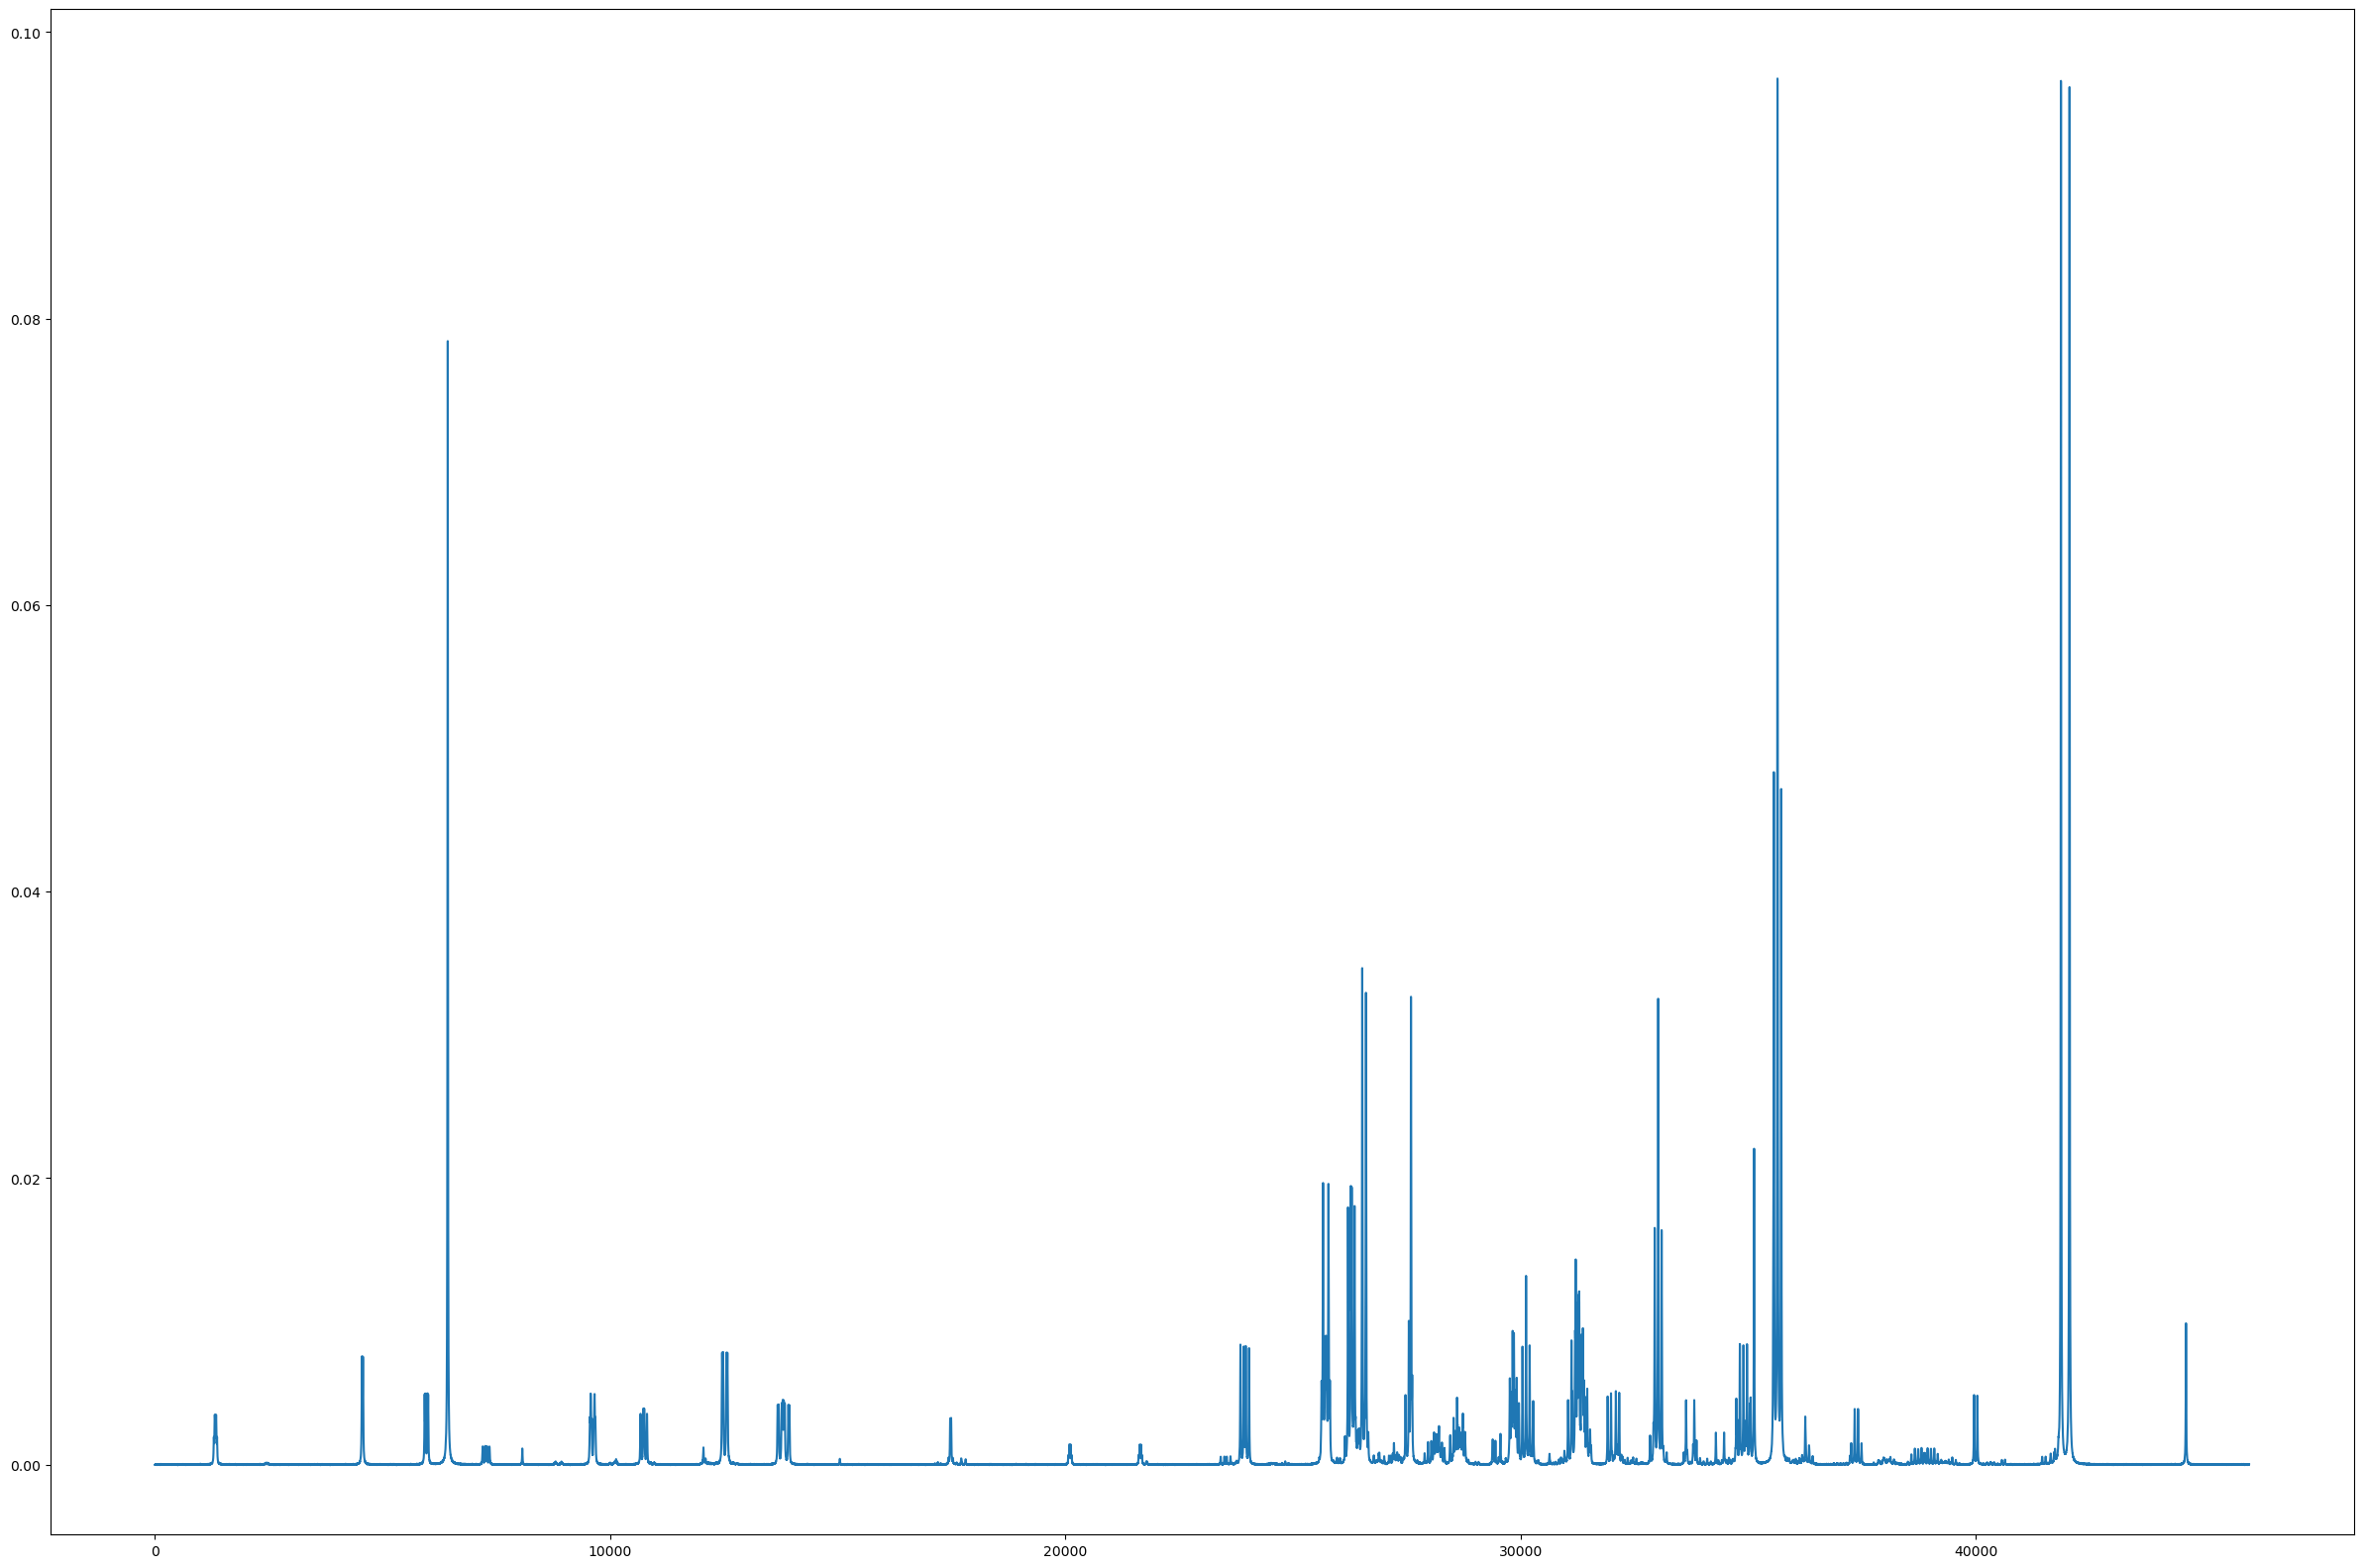

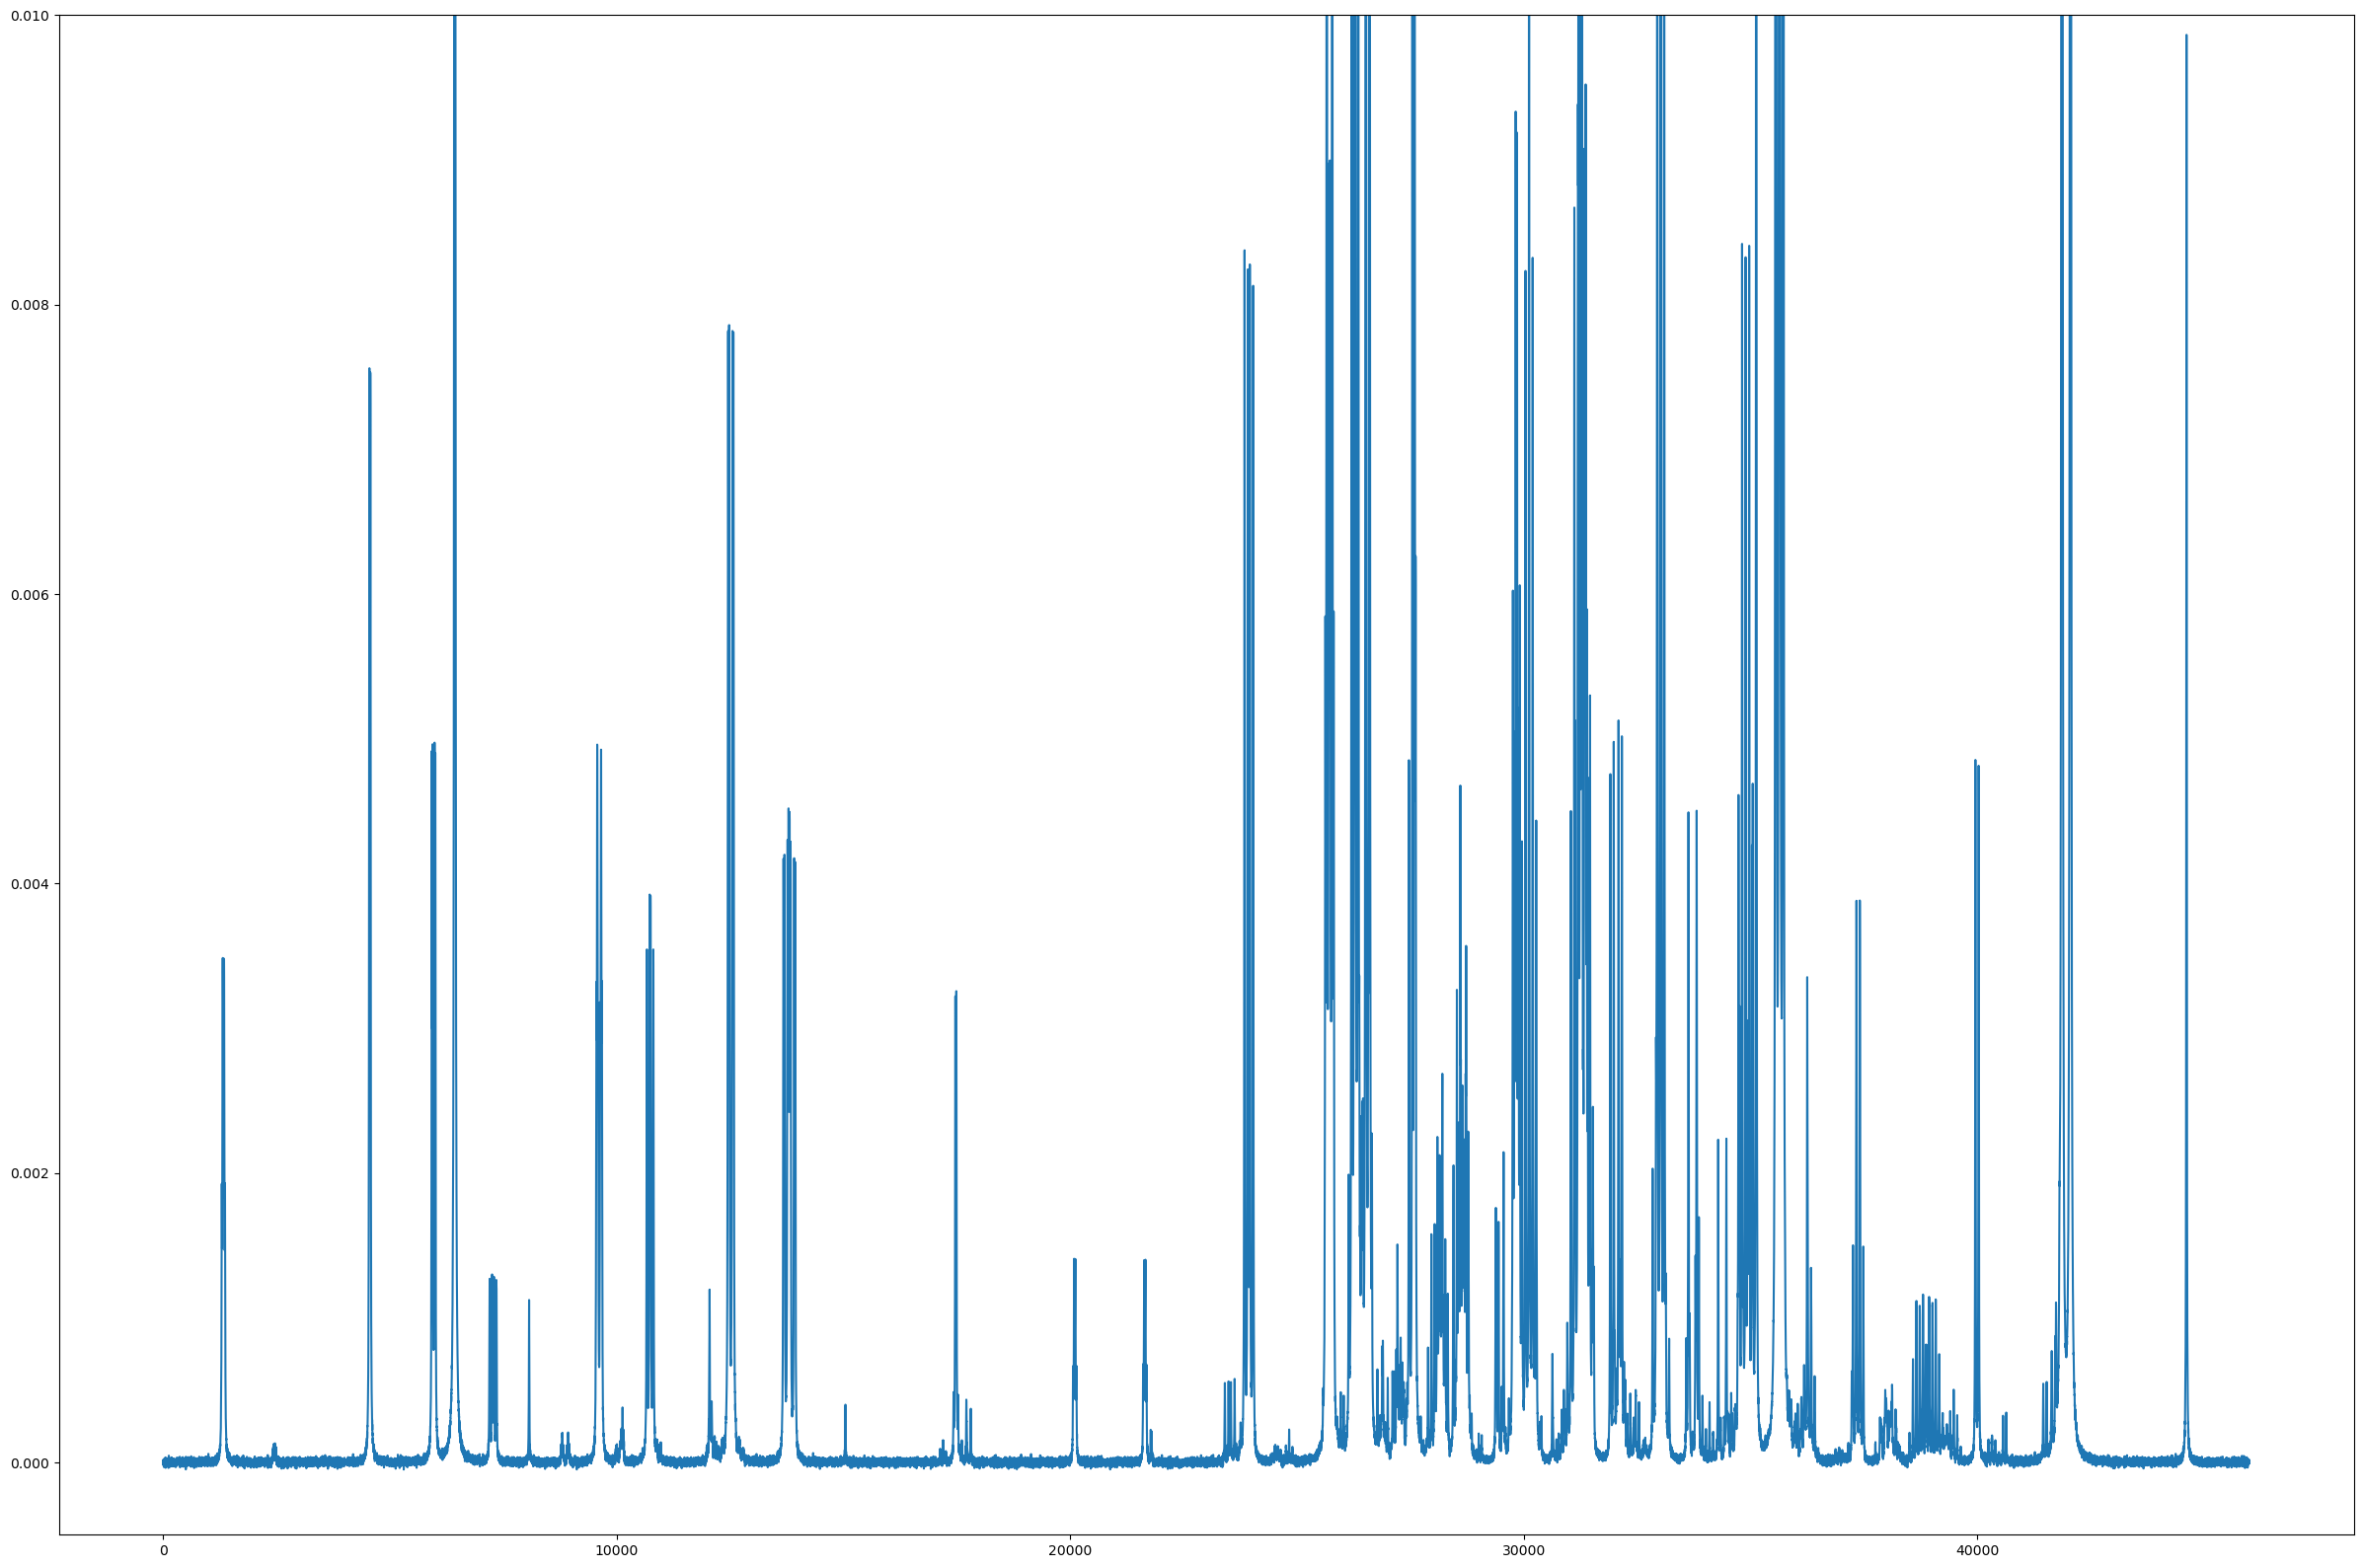

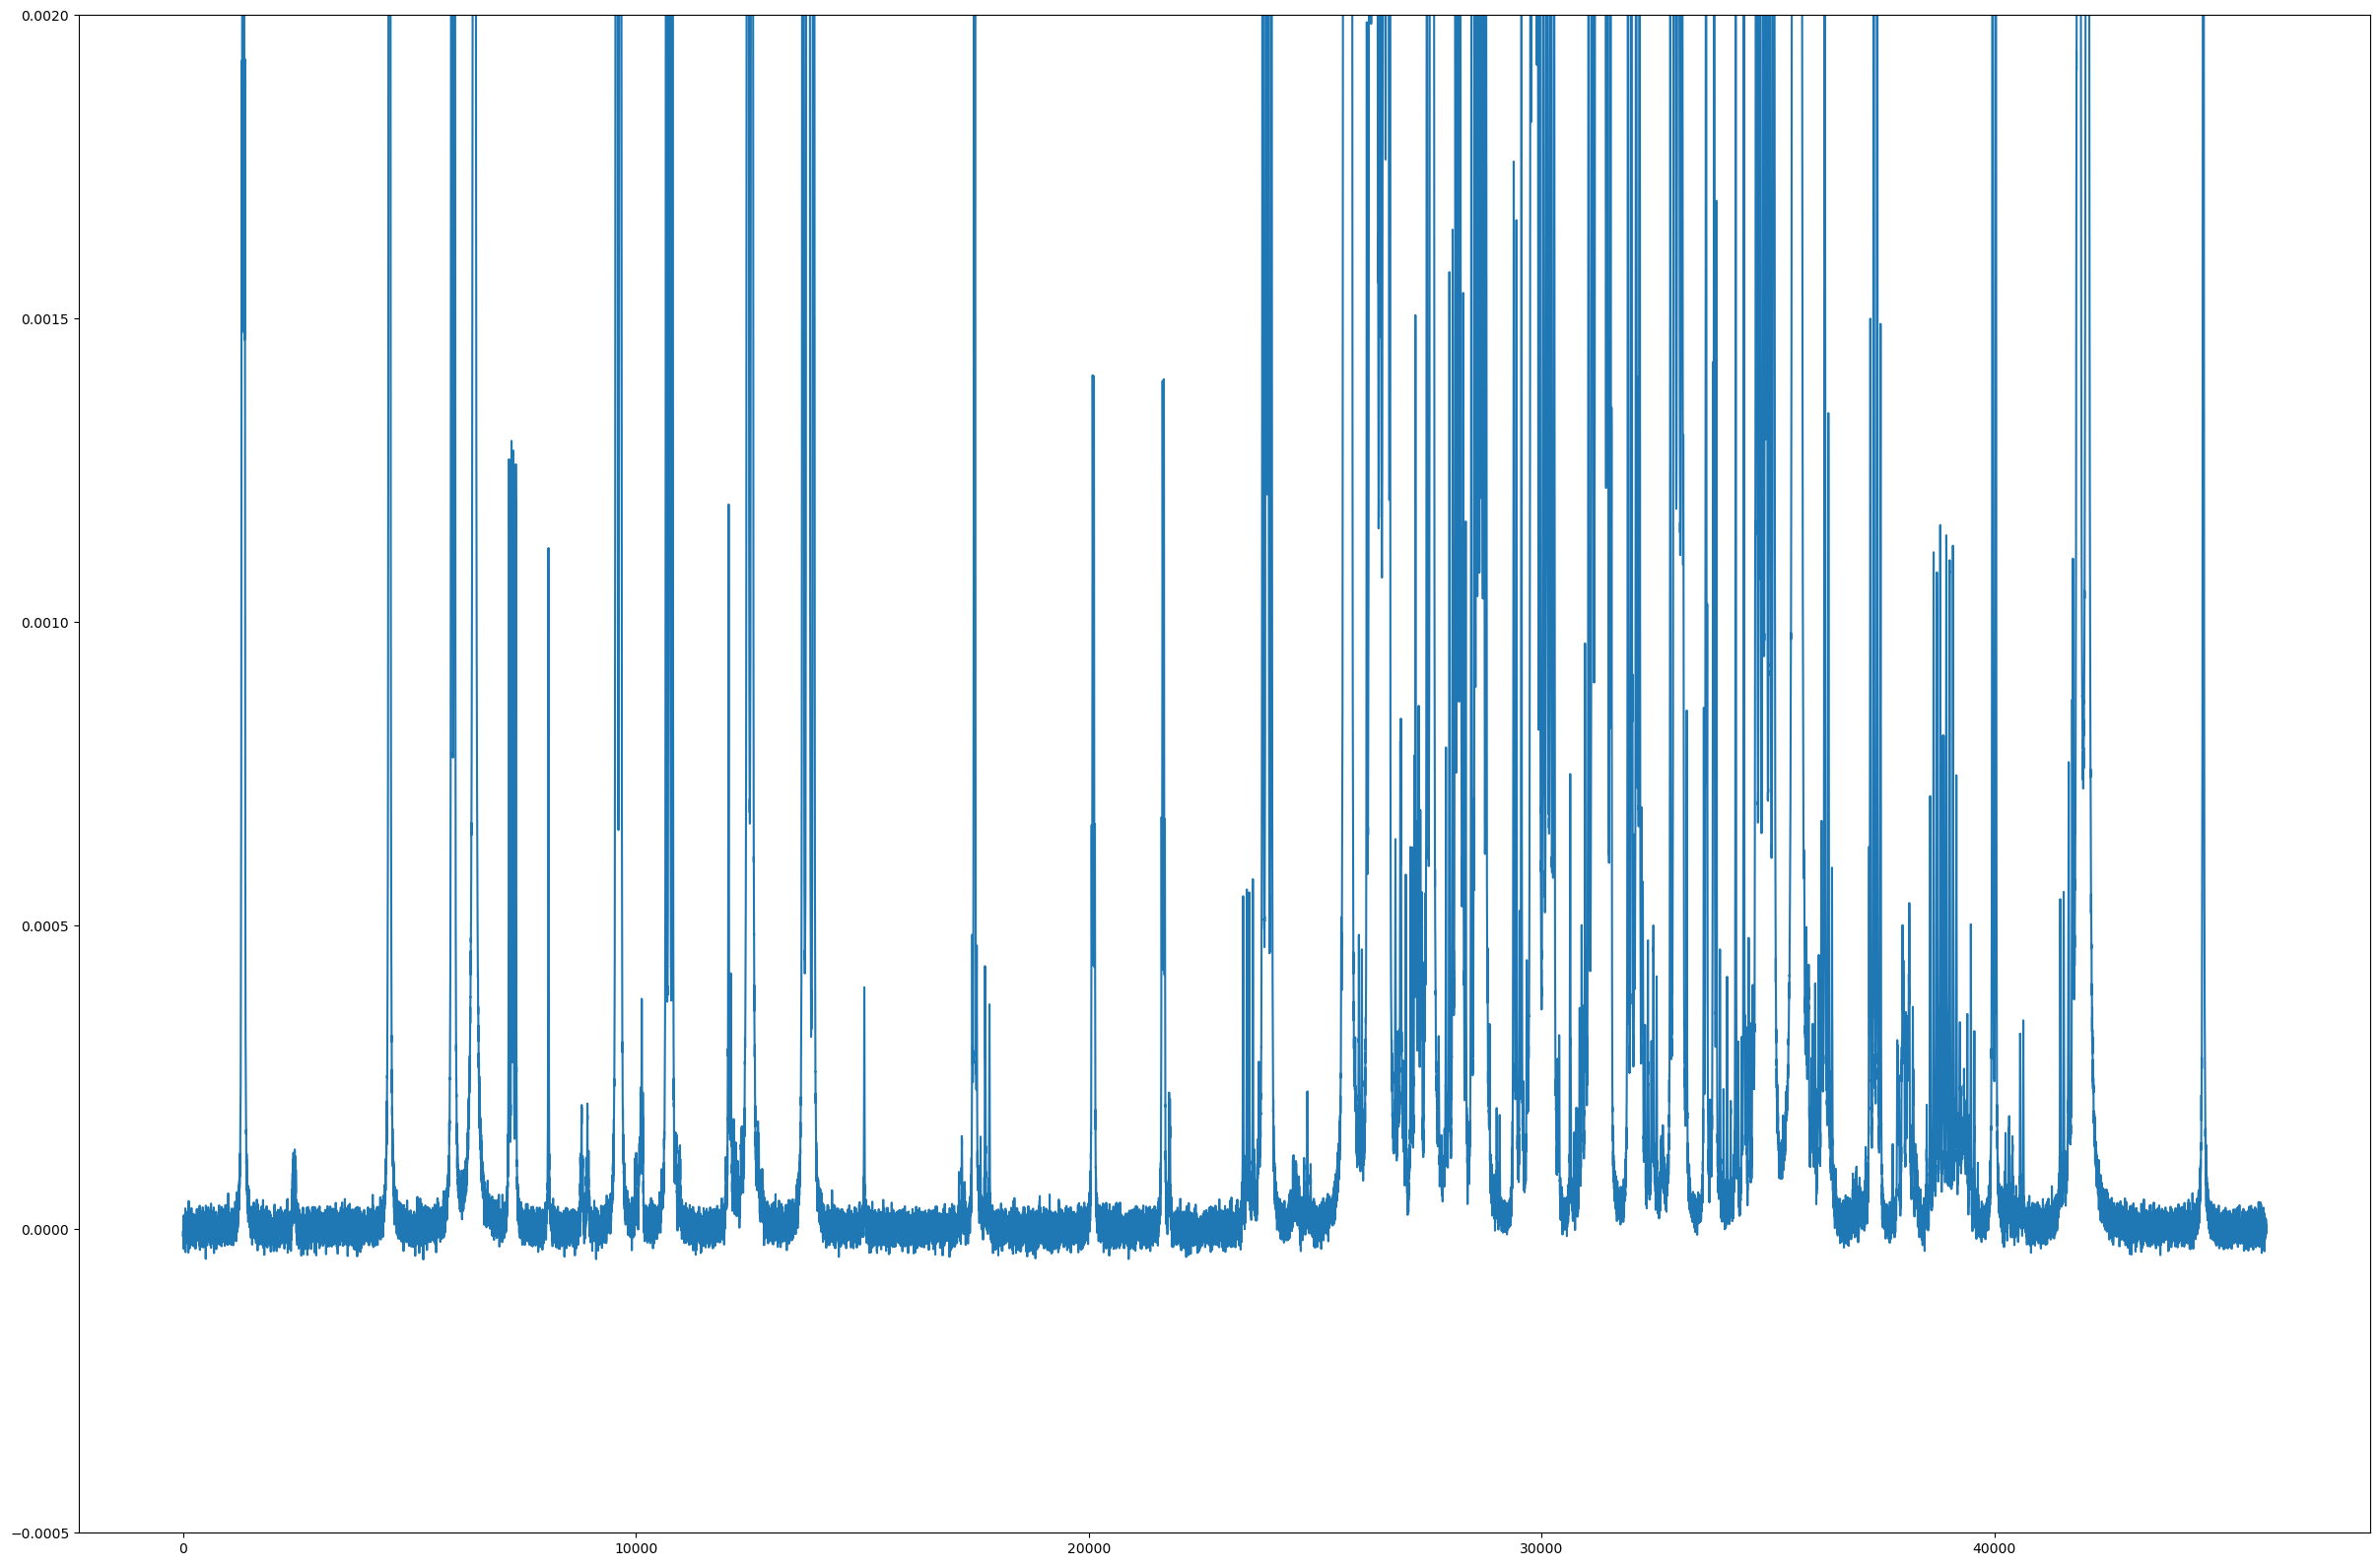

In [22]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [23]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  15.753099
--------------------
14.07  - Min Value: 0.013  - Mean Value: 0.6
13.02  - Min Value: 0.0115  - Mean Value: 0.4
12.81  - Min Value: 0.0115  - Mean Value: 0.4
11.85  - Min Value: 0.0115  - Mean Value: 0.6
13.85  - Min Value: 0.0115  - Mean Value: 1.0
21.83  - Min Value: 0.0115  - Mean Value: 1.1
27.6  - Min Value: 0.0115  - Mean Value: 0.8
10.52  - Min Value: 0.0115  - Mean Value: 0.5
10.02  - Min Value: 0.0115  - Mean Value: 0.5
21.97  - Min Value: 0.0115  - Mean Value: 1.1


In [24]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  79.515175
--------------------
56.96  - Min Value: 0.0062  - Mean Value: 2.1
53.78  - Min Value: 0.006  - Mean Value: 3.7
66.74  - Min Value: 0.0066  - Mean Value: 4.3
76.72  - Min Value: 0.0094  - Mean Value: 4.3
70.37  - Min Value: 0.0068  - Mean Value: 4.9
102.59  - Min Value: 0.005  - Mean Value: 3.8
64.36  - Min Value: 0.0101  - Mean Value: 3.2
46.66  - Min Value: 0.0062  - Mean Value: 3.2
93.04  - Min Value: 0.0053  - Mean Value: 5.3
163.93  - Min Value: 0.0054  - Mean Value: 2.5


In [25]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  1.5206231280814773
--------------------
1.23
1.25
1.52
1.34
1.37
1.51
1.88
1.46
1.73
1.92


In [26]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  15.884152531749857
--------------------
1.34
1.52
1.6
5.73
20.39
20.86
21.2
24.61
29.36
32.22


In [27]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  25.127060728474476
--------------------
2.09
7.6
13.21
18.55
24.35
29.08
33.32
37.48
41.28
44.32


In [28]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4698, 0.6505, 0.3847, 0.6604, 0.5016, 0.5298, 0.5234, 0.6810, 0.7720,
        0.4040, 0.4213, 0.7251, 0.5979, 0.9632, 0.2878, 0.7375, 0.6643, 0.4814,
        0.5222, 0.3941, 0.5149, 0.9873, 0.3707, 0.5536, 0.5957, 0.5095, 0.6381,
        0.7364, 0.5178, 0.4635, 0.4568, 0.9367, 0.4607, 0.4275, 0.4553, 0.5059,
        0.4941, 0.4797, 0.7491, 0.3871, 0.3988, 0.5317, 0.6560, 0.4361],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3741, 0.5362, 0.0154, 0.6223, 0.4090, 0.4200, 0.4162, 0.1252, 0.4277,
        0.5582, 0.3992, 0.4868, 0.8646, 0.4127, 0.8009, 0.0318, 0.9118, 0.5650,
        0.5084, 0.3309, 0.2225, 0.4412, 0.5779, 0.5108, 0.3474, 0.4664, 0.1474,
        0.0000, 0.5449, 0.3875, 0.4294, 0.3670, 0.3598, 0.4458, 0.5173, 0.5143,
        0.7059, 0.7798, 0.5453, 0.3424, 0.4255, 0.7897, 0.1614, 0.1815],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a